In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive/Colab Notebooks
!ls -la

/content/drive/My Drive/Colab Notebooks
total 548674
-rw------- 1 root root     19952 Oct  3 04:37 20174260.jpg
-rw------- 1 root root     36528 Sep 26 10:03 Cfia10.ipynb
-rw------- 1 root root     12535 Sep 26 02:25 Cw1CNN.ipynb
-rw------- 1 root root 280676800 Sep 29 17:40 cw1_wresnet.h5
-rw------- 1 root root 280678208 Sep 27 16:29 cw1wresnet.h5
-rw------- 1 root root    294010 Oct  4 09:17 cw2autoencodeer.ipynb
drwx------ 2 root root      4096 Oct  3 04:32 datasets
-rw------- 1 root root      8927 Sep 25 16:53 Mnist_CNN.ipynb
-rw------- 1 root root     39468 Oct  1 13:54 mnist.ipynb
-rw------- 1 root root     33600 Oct  1 04:42 nguyendangtien.ipynb
drwx------ 2 root root      4096 Oct  3 03:41 __pycache__
drwx------ 2 root root      4096 Oct  1 13:55 resnet_keras
-rw------- 1 root root      4723 Oct  3 04:32 resnets_utils.py
drwx------ 2 root root      4096 Oct  3 03:19 trained_model
-rw------- 1 root root      2538 Oct  2 15:14 WRESNET.ipynb
-rw------- 1 root root     15558 Oct  3

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from __future__ import print_function
from keras.models import Model
from keras.layers import Input, Dense,Reshape, Convolution2D, MaxPooling2D, UpSampling2D,Dropout
from keras.datasets import mnist, cifar10
from keras.regularizers import l1
from keras.optimizers import Adam
from resnets_utils import *
import skimage.measure

In [0]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()


In [0]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
#Convert rgb to gray (size = 64*64)
#X_train_orig = np.dot(X_train_orig[...,:3], [0.299, 0.587, 0.144])
#X_test_orig =  np.dot(X_test_orig[...,:3], [0.299, 0.587, 0.144])
#resize to 32*32
#X_new = np.zeros((1080,32,32))
#for i in range(1080):
#  X_new[i] = skimage.measure.block_reduce(X_train_orig[i], (2,2), np.max)
#X_train_orig = X_new
#################
#X_new1 = np.zeros((120,32,32))
#for i in range(120):
#  X_new1[i] = skimage.measure.block_reduce(X_test_orig[i], (2,2), np.max)
#X_test_orig = X_new1

# Normalize image vectors
x_train = X_train_orig/255.
x_test = X_test_orig/255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(1080, 12288)
(120, 12288)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


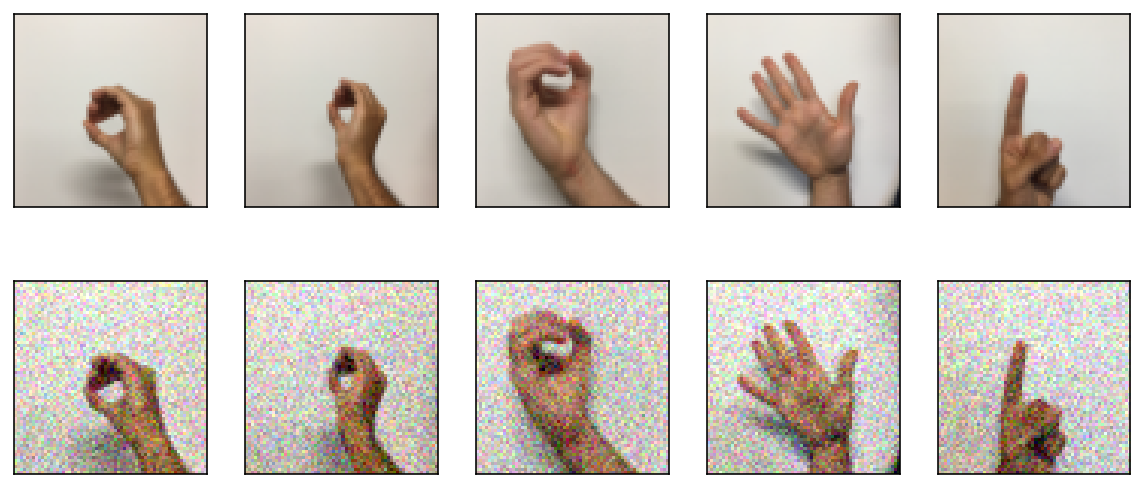

In [0]:
noise_factor = 0.1

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.5)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.5)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')


In [0]:
input_size = 12288

code_size = 32

input_img = Input(shape=(input_size,))
hidden_x = Dense(5096, activation='relu')(input_img)
x = Dropout(0,25)(hidden_x)
hidden_0 = Dense(2048, activation='relu')(x)
hidden_1 = Dense(1024, activation='relu')(hidden_0)
hidden_2 = Dense(512, activation='relu')(hidden_1)
hidden_3 = Dense(128, activation='relu')(hidden_2)

code = Dense(code_size, activation='relu')(hidden_1)

hidden_3 = Dense(128, activation='relu')(code)
hidden_2 = Dense(512, activation='relu')(hidden_3)
hidden_1 = Dense(1024, activation='relu')(hidden_2)
hidden_0 = Dense(2048, activation='relu')(hidden_1)
x = Dropout(0,25)(hidden_1)
hidden_x = Dense(5096, activation='relu')(x)

output_img = Dense(input_size, activation='sigmoid')(hidden_x)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=300)

Epoch 1/300
1080/1080 [==============================] - 10s 9ms/step - loss: 0.5834
Epoch 2/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5554
Epoch 3/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5550
Epoch 4/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5549
Epoch 5/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5549
Epoch 6/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5549
Epoch 7/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5596
Epoch 8/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5655
Epoch 9/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5552
Epoch 10/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5548
Epoch 11/300
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5505
Epoch 12/300
1080/1080 [==============================] - 6s 6ms/step - l

In [0]:
autoencoder.save('/content/drive/My Drive/Colab Notebooks/Cw2/cw2.h5')

In [0]:
from keras.models import load_model
autoencoder = load_model('/content/drive/My Drive/Colab Notebooks/Cw2/cw2.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

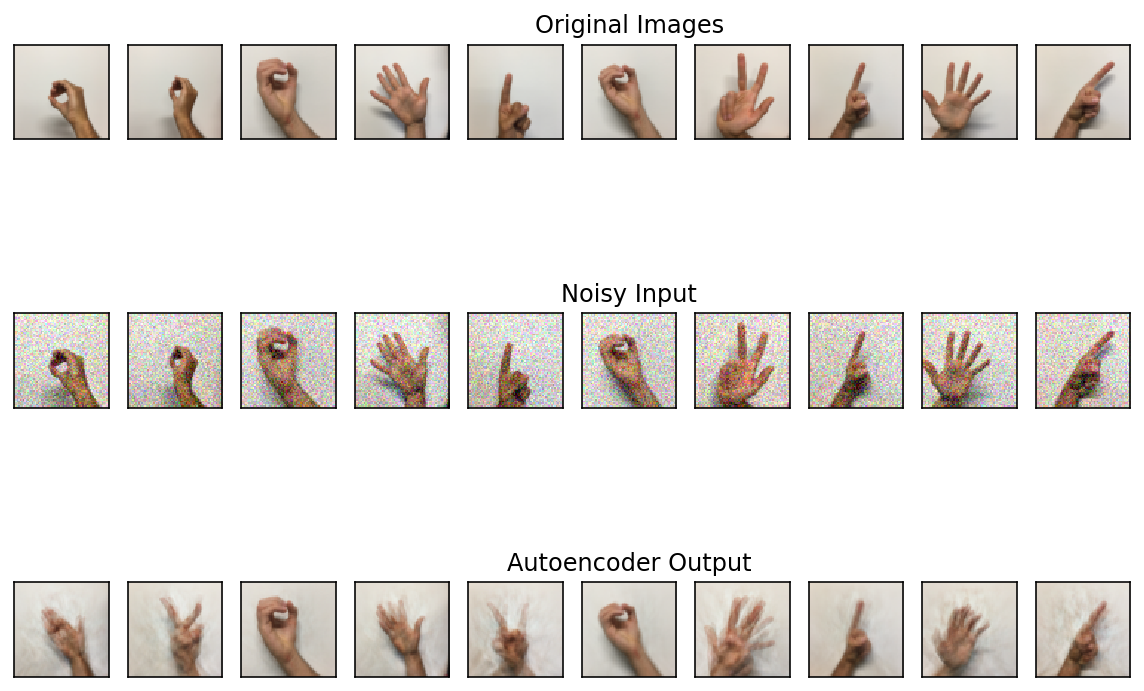

In [0]:
n = 10
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(64,64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(64,64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(64,64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')